In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import re
import sys
from matplotlib import axis

In [36]:
# read in data
df = pd.read_csv("vary_m.csv")

df.head()

,dataset,explainer,n_trees,max_depth,facet_m,iteration,index_time,accuracy,precision,recall,f1,per_valid,avg_dist,avg_length,prep_time,explain_time,sample_time,n_explain
0,glass,FACETIndex,10,5,2,0,0.036881,0.787879,0.8,0.842105,0.820513,1.0,0.128255,3.2,2.49097,0.072755,0.003638,20
1,glass,FACETIndex,10,5,3,0,0.054249,0.787879,0.8,0.842105,0.820513,1.0,0.128255,3.2,2.49097,0.047246,0.002362,20
2,glass,FACETIndex,10,5,4,0,0.072434,0.787879,0.8,0.842105,0.820513,1.0,0.128255,3.2,2.49097,0.040609,0.002030,20
3,glass,FACETIndex,10,5,5,0,0.090114,0.787879,0.8,0.842105,0.820513,1.0,0.128255,3.2,2.49097,0.034591,0.001730,20
4,glass,FACETIndex,10,5,6,0,0.109164,0.787879,0.8,0.842105,0.820513,1.0,0.128255,3.2,2.49097,0.029067,0.001453,20


In [41]:
# Group by m, dataset taking the average across each iteration
df_grouped = df.groupby(["dataset", "facet_m"], as_index=False).mean() 

df_grouped["explainer"] = "facet"


can_time = df_grouped[(df_grouped['facet_m'] == 4) & (df_grouped['dataset'] == "cancer")]["sample_time"]
glass_time = df_grouped[(df_grouped['facet_m'] == 4) & (df_grouped['dataset'] == "glass")]["sample_time"]
mag_time = df_grouped[(df_grouped['facet_m'] == 4) & (df_grouped['dataset'] == "magic")]["sample_time"]
spam_time = df_grouped[(df_grouped['facet_m'] == 4) & (df_grouped['dataset'] == "spambase")]["sample_time"]
vert_time = df_grouped[(df_grouped['facet_m'] == 4) & (df_grouped['dataset'] == "vertebral")]["sample_time"]

df_grouped["sample_time/m=4"] = df_grouped["sample_time"] * 0 

df_grouped.loc[df_grouped['dataset'] == "cancer", "sample_time/m=4"] = df_grouped[(df_grouped['dataset'] == "cancer")]["sample_time"] / float(can_time)
df_grouped.loc[df_grouped['dataset'] == "glass", "sample_time/m=4"] = df_grouped[(df_grouped['dataset'] == "glass")]["sample_time"] / float(glass_time)
df_grouped.loc[df_grouped['dataset'] == "magic", "sample_time/m=4"] = df_grouped[(df_grouped['dataset'] == "magic")]["sample_time"] / float(mag_time)
df_grouped.loc[df_grouped['dataset'] == "spambase", "sample_time/m=4"] = df_grouped[(df_grouped['dataset'] == "spambase")]["sample_time"] / float(spam_time)
df_grouped.loc[df_grouped['dataset'] == "vertebral", "sample_time/m=4"] = df_grouped[(df_grouped['dataset'] == "vertebral")]["sample_time"] / float(vert_time)

print(df_grouped.shape)
tmp_df = df_grouped[df_grouped['facet_m'] < 26] 

# cutoff spambase and cancer at M = 12
cutoff = 12
df_cancer = tmp_df[(tmp_df['facet_m'] < cutoff - 1) & (tmp_df['dataset'] == "cancer")] 
df_spam = tmp_df[(tmp_df['facet_m'] < cutoff) & (tmp_df['dataset'] == "spambase")]
df_other = tmp_df[(tmp_df['dataset'] != "spambase") & (tmp_df['dataset'] != "cancer")]

df_final = df_cancer.append(df_spam)
df_final = df_final.append(df_other)


df_final[["explainer", "dataset", "facet_m", "index_time", "sample_time", "sample_time/m=4"]]

(230, 19)


C:\Users\denni\AppData\Local\Temp\ipykernel_19828\3769481605.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_final = df_cancer.append(df_spam)
C:\Users\denni\AppData\Local\Temp\ipykernel_19828\3769481605.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_final = df_final.append(df_other)


,explainer,dataset,facet_m,index_time,sample_time,sample_time/m=4
0,facet,cancer,2,1.552860,0.020046,1.807034
1,facet,cancer,3,2.060582,0.012340,1.112400
2,facet,cancer,4,2.205402,0.011093,1.000000
3,facet,cancer,5,1.913123,0.011571,1.043067
4,facet,cancer,6,1.720472,0.013743,1.238878
...,...,...,...,...,...,...
203,facet,vertebral,21,1.656769,0.001508,0.566291
204,facet,vertebral,22,1.266352,0.004840,1.817286
205,facet,vertebral,23,1.046301,0.009013,3.384081
206,facet,vertebral,24,1.034582,0.009112,3.421109


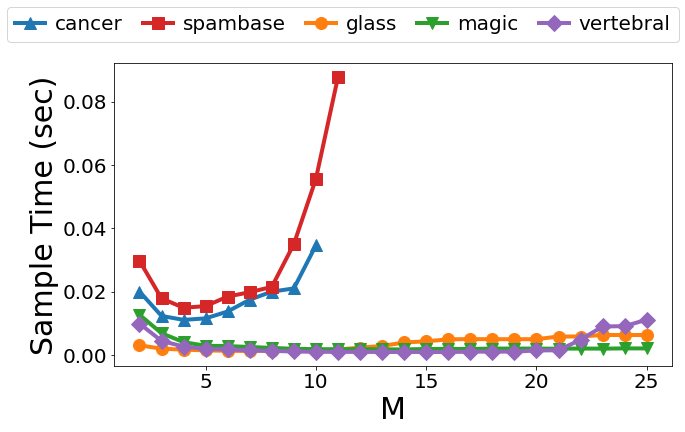

In [42]:
# create viz
fig = plt.figure(figsize=[10, 4.8], frameon=True)
ax = fig.add_subplot(1, 1, 1)
results = df_final
xfeature = "facet_m"
yfeature = "sample_time"
line_width = 4
cmap = plt.get_cmap("tab10")
colors = cmap.colors
ds_colors = {
    "cancer": colors[0],
    "glass": colors[1],
    "magic": colors[2],
    "spambase": colors[3],
    "vertebral": colors[4]
}
ds_markers = {
    "cancer": "^",
    "glass": "o",
    "magic": "v",
    "spambase": "s",
    "vertebral": "D"
}
marker_size = 12
line_width = 4
marker_sizes = {
    "cancer": marker_size,
    "glass": marker_size,
    "magic": marker_size,
    "spambase": marker_size,
    "vertebral": marker_size
}
title = None
xlabel = "M"
ylabel = "Sample Time (sec)"
lhorz = True
loc = "upper center"
xrange = None
yrange = None
ylog = False
xlog = False

for ds in results["dataset"].unique():
        is_ds = results["dataset"] == ds
        for expl in results["explainer"].unique():
            is_expl = results["explainer"] == expl
            matching_rows = is_ds & is_expl
            ax.plot(results[matching_rows][xfeature], results[matching_rows][yfeature], label=ds, lw=line_width, marker=ds_markers[ds], ms=marker_sizes[ds], color=ds_colors[ds])

        # title and axis labels
        if title is not None:
            plt.title(title)
        plt.xlabel(xlabel,fontsize=30)
        plt.ylabel(ylabel,fontsize=30)
        # legend
        if lhorz:
            plt.legend(loc=loc, ncol=len(results["dataset"].unique()), bbox_to_anchor=(0, 1.22, 0.82, 0), handletextpad=0.5, columnspacing=1, handlelength=1.5, prop={"size":20})
        else:
            plt.legend(loc=loc)
        # x and y ranges
        if xrange is not None:
            plt.xlim(xrange)
        if yrange is not None:
            plt.ylim(yrange)
        # x and y scales
        if ylog:
            plt.yscale('log')
        if xlog:
            plt.xscale('log')
        plt.subplots_adjust(top=1.0)
        plt.xticks(fontsize=20)
        plt.yticks(fontsize=20)

plt.savefig("vary_m.pdf", bbox_inches="tight")

